<a href="https://colab.research.google.com/github/Dasuntharaka111/ARIMA-Time-Series-Forecasting/blob/main/SARIMA_Champagne_Sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.23.5 scipy==1.10.1
!pip install pmdarima


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error


import data & preprocessing

In [3]:
def load_champagne_data():
    url = "/content/monthly-champagne.csv"
    df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
    df.columns = ['Sales']
    df = df.dropna()
    print(df.head())
    return df['Sales']



In [4]:
load_data=load_champagne_data()


          Sales
Month          
1964-01  2815.0
1964-02  2672.0
1964-03  2755.0
1964-04  2721.0
1964-05  2946.0


In [5]:
def test_stationarity(timeseries):
    """Perform Dickey-Fuller test for stationarity"""
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

In [6]:
def plot_acf_pacf(ts, lags=40):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(ts.dropna(), lags=lags, ax=ax1)
    plot_pacf(ts.dropna(), lags=lags, ax=ax2)
    plt.tight_layout()
    plt.show()

# Split train-test
def split_data(ts, test_size=0.2):
    split_idx = int(len(ts) * (1 - test_size))
    return ts[:split_idx], ts[split_idx:]

# Evaluate model
def evaluate_model(model, train_data, test_data):
    """Evaluate model performance and handle NaNs in predictions."""
    predictions = model.predict(start=train_ts.index[0],
                                end=train_ts.index[-1],
                                typ='levels')

    # Align index with test data
    valid_idx = predictions.dropna().index
    predictions = predictions.loc[valid_idx]
    test_data = test_data.loc[valid_idx]

    # Evaluate only on valid data
    mae = mean_absolute_error(test_data, predictions)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    return predictions

#Visualization
def plot_results(train,test, predictions, title):
    plt.figure(figsize=(14, 7))
    train.plot(label='Training Data')
    #test.plot(label='Actual Values')
    predictions.index = test.index  # Align index
    predictions.plot(label='Forecast')
    plt.title(title)
    plt.legend()
    plt.show()


          Sales
Month          
1964-01  2815.0
1964-02  2672.0
1964-03  2755.0
1964-04  2721.0
1964-05  2946.0


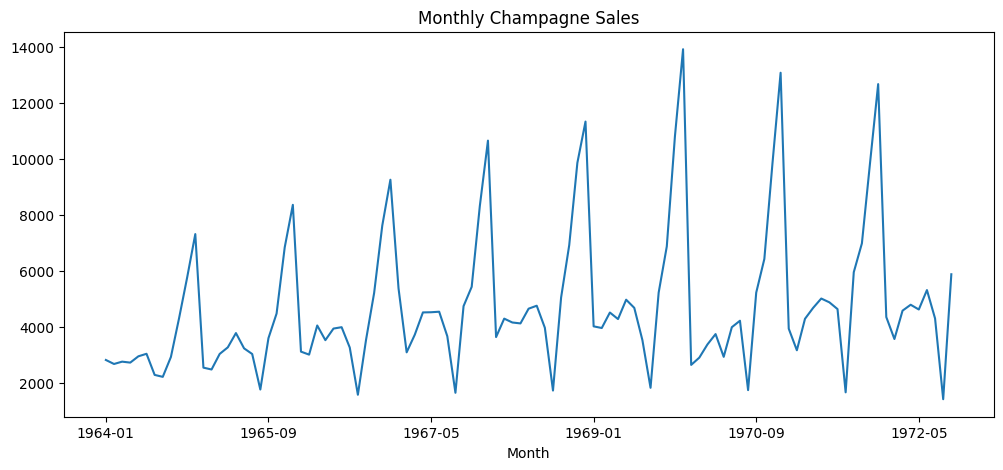


Initial Stationarity Test:
Results of Dickey-Fuller Test:
Test Statistic                 -1.833593
p-value                         0.363916
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64

ACF/PACF:


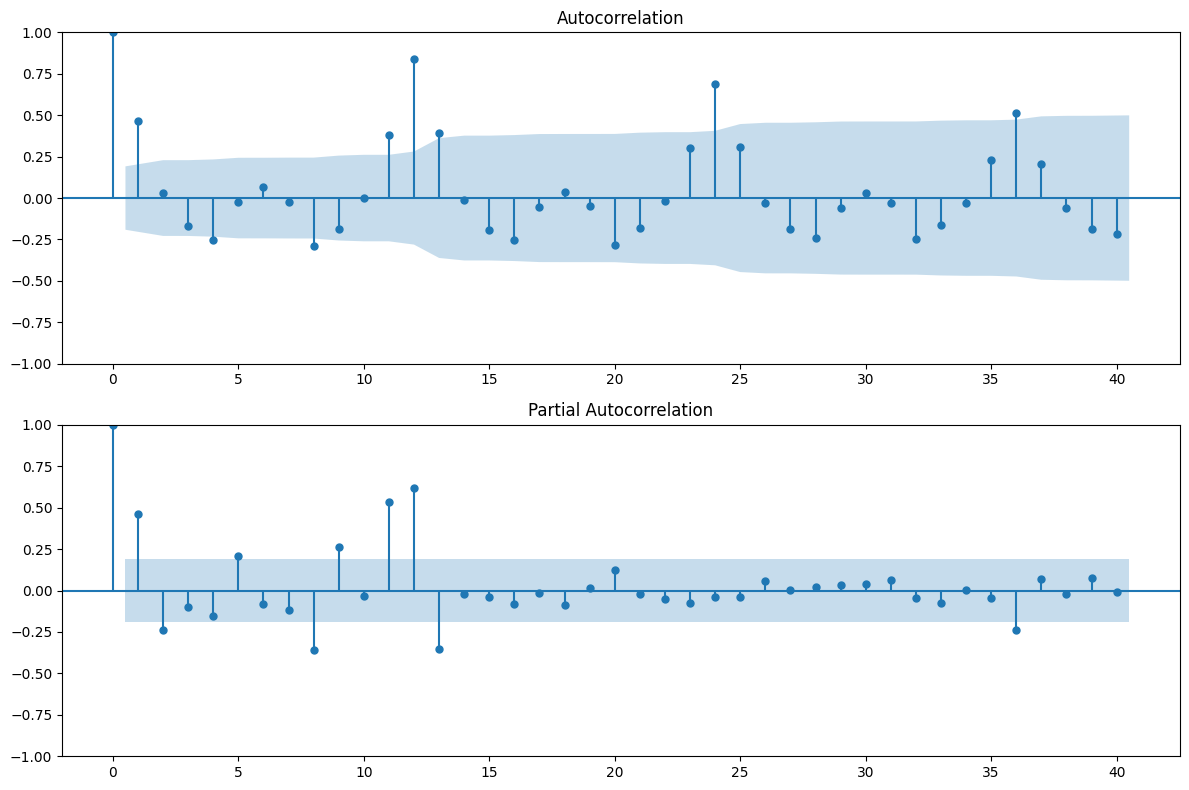


After 2nd Differencing:
Results of Dickey-Fuller Test:
Test Statistic                -7.924775e+00
p-value                        3.643435e-12
#Lags Used                     1.300000e+01
Number of Observations Used    8.900000e+01
Critical Value (1%)           -3.506057e+00
Critical Value (5%)           -2.894607e+00
Critical Value (10%)          -2.584410e+00
dtype: float64


In [7]:
champagne_ts = load_champagne_data()

# Plot original time series
champagne_ts.plot(figsize=(12, 5), title='Monthly Champagne Sales')
plt.show()

# Stationarity test
print("\nInitial Stationarity Test:")
test_stationarity(champagne_ts)

# ACF/PACF
print("\nACF/PACF:")
plot_acf_pacf(champagne_ts, lags=40)

# Differenced series to check stationarity improvement
champagne_diff2 = champagne_ts.diff().diff().dropna()
print("\nAfter 2nd Differencing:")
test_stationarity(champagne_diff2)

In [8]:
train_ts, test_ts = split_data(champagne_ts)

# Auto ARIMA to find best model
auto_model = auto_arima(train_ts,
                        seasonal=True,
                        m=12,
                        start_p=0, max_p=5, start_q=0, max_q=5,
                        d=1, max_d=2,
                        start_P=0, max_P=3, start_Q=0, max_Q=3,
                        D=1, max_D=2,
                        trace=True, stepwise=True, n_jobs=-1)

print(f"\nOptimal Order: {auto_model.order}, Seasonal Order: {auto_model.seasonal_order}")



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1183.693, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1173.736, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1157.042, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1155.109, Time=0.09 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1157.009, Time=0.27 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1158.348, Time=0.70 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1155.379, Time=0.15 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1155.138, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1173.612, Time=0.05 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1155.790, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 2.284 seconds

Optimal Order: (0, 1, 1), Seasonal Order: (0, 1, 0, 12)


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -558.356
Date:                             Fri, 09 May 2025   AIC                           1120.712
Time:                                     04:15:24   BIC                           1125.180
Sample:                                 01-01-1964   HQIC                          1122.484
                                      - 12-01-1970                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8775      0.075    -11.717      0.000      -1.024      -0.731
sigma2      7.397e+05   1.1

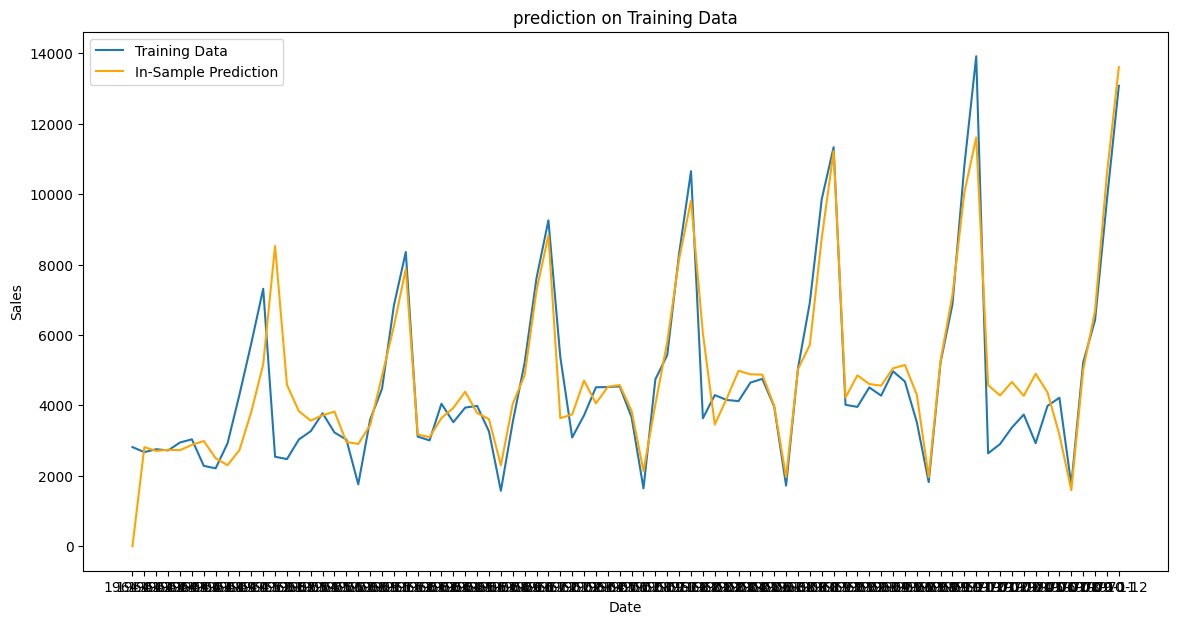

In [9]:
sarima_model = SARIMAX(train_ts,
                       order=(0,1,1),
                       seasonal_order=(0,1,0,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()

# Model summary
print(sarima_model.summary())

# Evaluate and plot results
train_preds = sarima_model.predict(start=train_ts.index[0], end=train_ts.index[-1], typ='levels')

# Align index with training data
train_preds.index = train_ts.index

# Plot
plt.figure(figsize=(14, 7))
plt.plot(train_ts, label='Training Data')
plt.plot(train_preds, label='In-Sample Prediction', color='orange')
plt.legend()
plt.title('prediction on Training Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


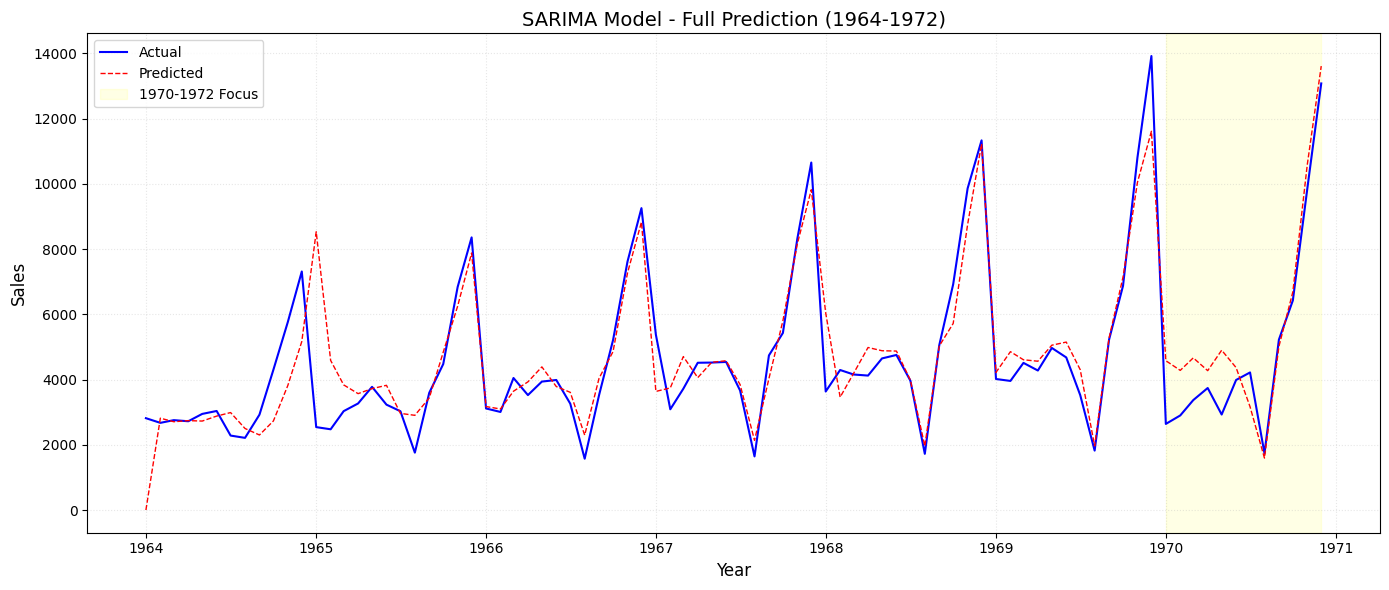


Last 3 Years Comparison (1970-1972):
             Actual  Predicted
1970-01-01   2639.0     4576.7
1970-02-01   2899.0     4280.4
1970-03-01   3370.0     4664.2
1970-04-01   3740.0     4271.7
1970-05-01   2927.0     4898.6
1970-06-01   3986.0     4366.1
1970-07-01   4217.0     3165.5
1970-08-01   1738.0     1592.3
1970-09-01   5221.0     5011.2
1970-10-01   6424.0     6686.9
1970-11-01   9842.0    10585.7
1970-12-01  13076.0    13607.6


In [10]:
# Prepare data (convert index to datetime)
train_ts.index = pd.to_datetime(train_ts.index, format='%Y-%m')

# Generate predictions for entire period
all_preds = sarima_model.predict(
    start=train_ts.index[0],
    end=train_ts.index[-1],
    typ='levels'
)

# Plot full results
plt.figure(figsize=(14, 6))
plt.plot(train_ts.index, train_ts, label='Actual', color='blue', linewidth=1.5)
plt.plot(all_preds.index, all_preds, label='Predicted', color='red', linestyle='--', linewidth=1)

# Format x-axis for yearly clarity
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only years
ax.xaxis.set_major_locator(mdates.YearLocator())  # Tick every year

# Style enhancements
plt.title('SARIMA Model - Full Prediction (1964-1972)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.3)

# Highlight the last 3 years (1970-1972)
highlight = train_ts['1970-01':'1972-12']
plt.axvspan(highlight.index[0], highlight.index[-1], color='yellow', alpha=0.1, label='1970-1972 Focus')

plt.legend()
plt.tight_layout()
plt.show()

# Print last 3 years comparison
print("\nLast 3 Years Comparison (1970-1972):")
print(pd.DataFrame({
    'Actual': train_ts['1970-01':'1972-12'],
    'Predicted': all_preds['1970-01':'1972-12']
}).round(1))

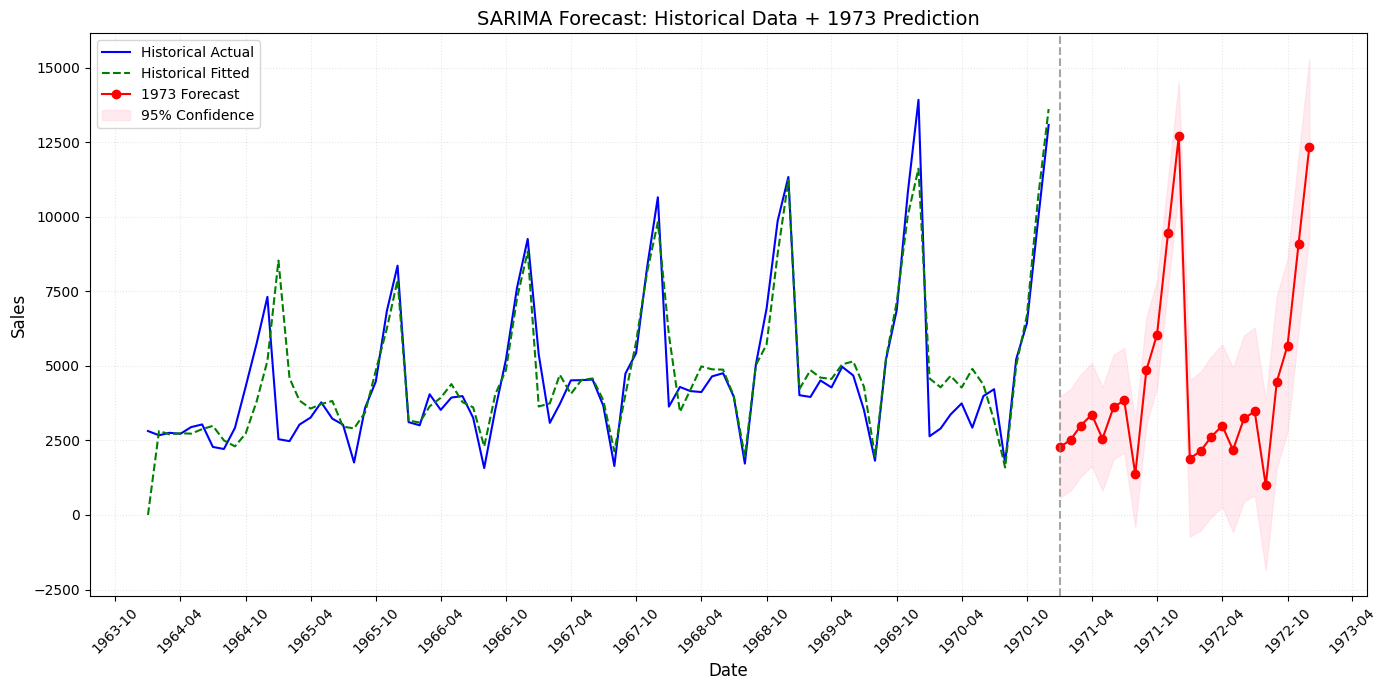


1973 Monthly Forecast:
         Forecast  Lower CI  Upper CI
Date                                 
1971-01    2265.5     579.8    3951.1
1971-02    2525.5     827.2    4223.7
1971-03    2996.5    1285.7    4707.2
1971-04    3366.5    1643.3    5089.6
1971-05    2553.5     818.0    4289.0
1971-06    3612.5    1864.8    5360.2
1971-07    3843.5    2083.6    5603.4
1971-08    1364.5    -407.5    3136.4
1971-09    4847.5    3063.5    6631.4
1971-10    6050.5    4254.6    7846.3
1971-11    9468.5    7660.8   11276.2
1971-12   12702.5   10883.1   14521.9
1972-01    1892.0    -733.0    4516.9
1972-02    2152.0    -505.3    4809.2
1972-03    2623.0     -66.2    5312.1
1972-04    2993.0     272.3    5713.6
1972-05    2180.0    -571.8    4931.8
1972-06    3239.0     456.4    6021.6
1972-07    3470.0     656.9    6283.0
1972-08     991.0   -1852.3    3834.2
1972-09    4474.0    1600.9    7347.0
1972-10    5677.0    2774.4    8579.5
1972-11    9095.0    6163.2   12026.7
1972-12   12329.0    9368.

In [11]:
# Prepare data (ensure datetime index)
train_ts.index = pd.to_datetime(train_ts.index, format='%Y-%m')

# Forecast next 12 months (1973)
forecast_steps = 24
forecast = sarima_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=train_ts.index[-1] + pd.DateOffset(months=1),
                             periods=forecast_steps, freq='MS')
forecast_values = forecast.predicted_mean

# Create combined plot
plt.figure(figsize=(14, 7))

# Historical data and predictions
plt.plot(train_ts.index, train_ts, label='Historical Actual', color='blue')
plt.plot(train_ts.index, sarima_model.fittedvalues, label='Historical Fitted',
        color='green', linestyle='--')

# Forecasted values
plt.plot(forecast_index, forecast_values, label='1973 Forecast',
        color='red', marker='o')

# Confidence interval
plt.fill_between(forecast_index,
                forecast.conf_int()['lower Sales'],
                forecast.conf_int()['upper Sales'],
                color='pink', alpha=0.3, label='95% Confidence')

# Formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

plt.title('SARIMA Forecast: Historical Data + 1973 Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.3)

# Add vertical line at forecast start
forecast_start = forecast_index[0]
plt.axvline(x=forecast_start, color='gray', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print forecast table
print("\n1973 Monthly Forecast:")
print(pd.DataFrame({
    'Date': forecast_index.strftime('%Y-%m'),
    'Forecast': forecast_values.round(1),
    'Lower CI': forecast.conf_int()['lower Sales'].round(1),
    'Upper CI': forecast.conf_int()['upper Sales'].round(1)
}).set_index('Date'))